In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat
from scipy.stats import uniform as sp_uniform

from sklearn.datasets import load_wine
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

In [2]:
data = load_wine().data
f_names = load_wine().feature_names
df = pd.DataFrame(data, columns=f_names)

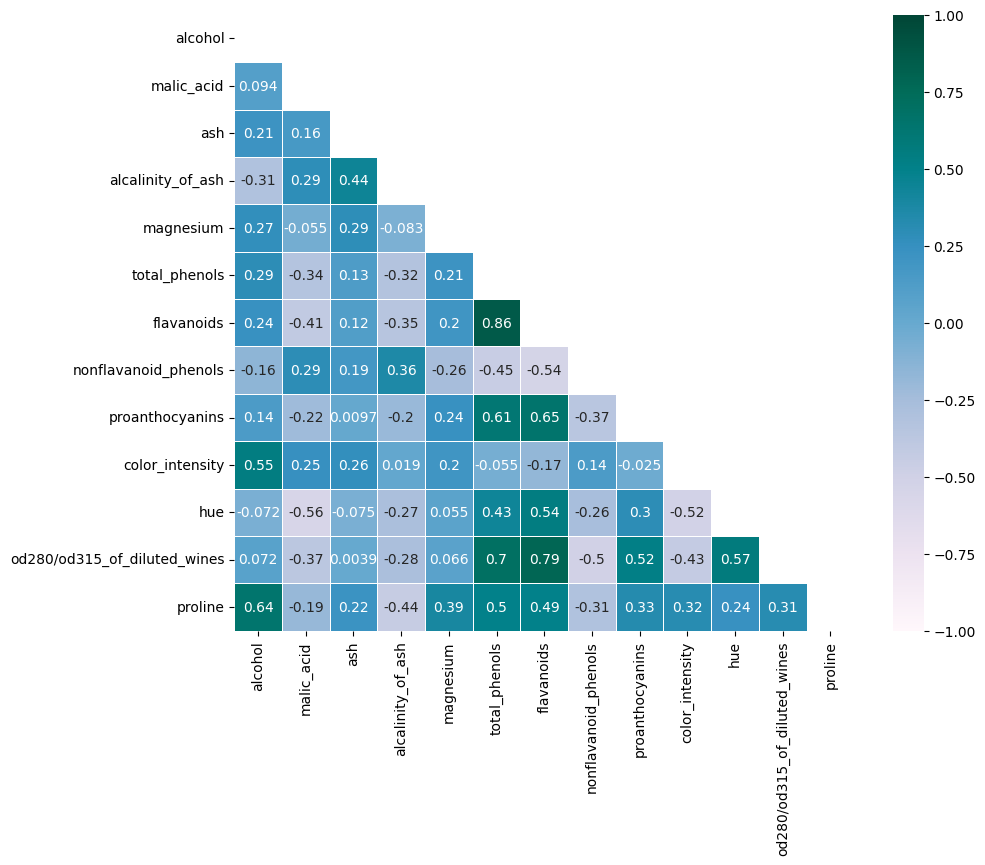

In [3]:
corr = df.corr()
matrix = np.triu(corr)
plt.figure(figsize=(10,8))
sns.heatmap(corr, mask = matrix,
            annot=True,
            cmap = 'PuBuGn',
            linewidths = 0.5,
            vmin = -1, vmax = 1)
plt.show()

In [22]:
# Those with close ccorelation with target
cols = corr.index[corr['alcohol'] > .25].tolist()
cols = cols[1:]

# Preparing for spliting data
y_c = df['alcohol']
X_c = df[cols]

X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_c, y_c,
                                                    test_size=.1,
                                                    random_state=42)
print(f'Train rows: {X_trainc.shape[0]}')
print(f'test rows: {X_testc.shape[0]}')

Train rows: 160
test rows: 18


Split the data set

In [23]:
# Scale with MinMax method
mms = MinMaxScaler()
X_trainc = mms.fit_transform(X_trainc)
X_testc = mms.transform(X_testc)

In [38]:
r2l = []
bestR2 = -100

for i in np.arange(2,20):
    knnr = KNeighborsRegressor(n_neighbors=i)
    knnr.fit(X_trainc, y_trainc)
    y_pred = knnr.predict(X_testc)
    r2 = r2_score(y_testc, y_pred)
    r2l.append(r2)

    if r2 > bestR2:
      bestR2 = r2
      i_best = i


print(f' Best Setting:\n R2= {bestR2:.3f}\n Neighbors= {i_best}')

 Best Setting:
 R2= 0.795
 Neighbors= 12


In [31]:
rf = RandomForestRegressor(max_depth= 5,
                           max_features= 'log2',
                           min_samples_leaf= 5,
                           min_samples_split= 8,
                           n_estimators= 100,
                           random_state = 42)

rf.fit(X_trainc, y_trainc)
rf_pred = rf.predict(X_testc)
r2_rf = r2_score(y_testc, rf_pred)
print(f'R2 Score: {r2_rf:.3f}')

R2 Score: 0.768


In [32]:
models = {  'knn': KNeighborsRegressor(),
            'random_forest': RandomForestRegressor(),
            'SVR': SVR(), 'ridge': Ridge(), 'lasso': Lasso(),
            'linear_regression': LinearRegression()
            #'elastic_net': ElasticNet()
         }

results = {}

# Define hyper parameters with grid search
param_grid = {
    'linear_regression': {},
    'knn': {'n_neighbors': list(range(3, 20)), 'weights': ['uniform', 'distance']},
    'random_forest': {'n_estimators': [10, 20, 30, 50, 70, 90],
                      'max_depth': [None] + list(range(5, 20))},
    'SVR': {'C': [0.1, 1, 5, 10], 'kernel': ['linear', 'rbf', 'poly'],
            'epsilon': [0.01, 0.1, 0.5, 1]},
    'ridge': {'alpha': [0.01, .1, 1.5, 10, 50]},
    'lasso': {'alpha': [0.01, .1, 1.5, 10, 50]},
    'elastic_net': {'alpha': [0.01, .1, 1.5, 10, 50], 'l1_ratio': [.01, .1, .3, .5, .9]}
             }

In [34]:
for name, model in models.items():
# Grid_search:
  gs = GridSearchCV(estimator = model, cv = 5,
                    param_grid = param_grid[name],
                    scoring = 'r2',
                    n_jobs = -1,)

  gs.fit(X_trainc,y_trainc)
  best_model = gs.best_estimator_
  ypred = best_model.predict(X_testc)
  rmse = np.sqrt(mean_squared_error(y_testc, ypred))
  r2 = r2_score(y_testc, ypred)
  results[name] = {'RMSE':rmse, 'R2': r2, 'Best params': gs.best_params_}

for name,metric in results.items():
  print(f' Model- {name}')
  print(f' R2: {metric["R2"]:.3f} /\ RMSE: {metric["RMSE"]:.3f} ')
  print(f"Best Parameters: {metric['Best params']}")
  print(10*'//////')

 Model- knn
 R2: 0.779 /\ RMSE: 0.390 
Best Parameters: {'n_neighbors': 19, 'weights': 'distance'}
////////////////////////////////////////////////////////////
 Model- random_forest
 R2: 0.715 /\ RMSE: 0.444 
Best Parameters: {'max_depth': 7, 'n_estimators': 50}
////////////////////////////////////////////////////////////
 Model- SVR
 R2: 0.618 /\ RMSE: 0.513 
Best Parameters: {'C': 1, 'epsilon': 0.5, 'kernel': 'linear'}
////////////////////////////////////////////////////////////
 Model- ridge
 R2: 0.621 /\ RMSE: 0.512 
Best Parameters: {'alpha': 0.1}
////////////////////////////////////////////////////////////
 Model- lasso
 R2: 0.623 /\ RMSE: 0.511 
Best Parameters: {'alpha': 0.01}
////////////////////////////////////////////////////////////
 Model- linear_regression
 R2: 0.622 /\ RMSE: 0.511 
Best Parameters: {}
////////////////////////////////////////////////////////////
